In [42]:
label_map = {0: "Angry", 1: "Fear", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Surprise"}

In [43]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Embedding, Activation, \
MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D, Flatten, BatchNormalization
from keras.applications import VGG16

In [150]:
from keras.optimizers import Adam, SGD

model_1 = VGG16(weights = 'imagenet', input_shape=(224, 224, 3), include_top = False)

model_1.trainable = False


model_2 = Sequential()

model_2.add(Conv2D(128, (5, 5), padding='same', input_shape=model_1.output_shape[1:]))
model_2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(SpatialDropout2D(0.25))

model_2.add(Flatten())

model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(6, activation='softmax'))

model = Model(inputs=model_1.input, outputs=model_2(model_1.output))
    
model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model.load_weights("/Users/jasur/desktop/CustomVGG.h5 copy 2")

In [152]:
for layer in model.layers:
    print(layer.name)

input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
sequential_7


In [68]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.optimizers import Adam, SGD

import tensorflow as tf

import numpy as np
import cv2

# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
img_path = "/Users/jasur/desktop/FER13/test/happy/PublicTest_83630896.jpg"
orig = cv2.imread(img_path)
resized = cv2.resize(orig, (224, 224))


# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img(img_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 262ms/step


In [69]:
preds, i

(array([[1.5994634e-11, 3.9282994e-04, 9.9951828e-01, 0.0000000e+00,
         0.0000000e+00, 8.8864574e-05]], dtype=float32),
 2)

In [70]:
# decode the ImageNet predictions to obtain the human-readable label
#decoded = imagenet_utils.decode_predictions(preds)
#(imagenetID, label, prob) = decoded[0][0]
decoded = i, label_map[i], preds[0][i]
print("decoded: ", decoded)
(imagenetID, label, prob) = decoded
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

decoded:  (2, 'happy', 0.9995183)
[INFO] happy: 99.95%


In [71]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs = \
                          [self.model.get_layer(self.layerName).output, self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [89]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i, "block5_conv3")
heatmap = cam.compute_heatmap(image)

In [90]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.6)

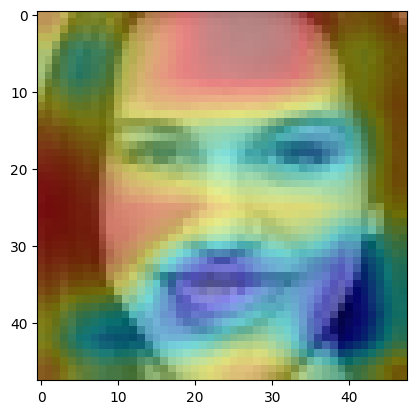

In [74]:
plt.imshow(output)
plt.show()

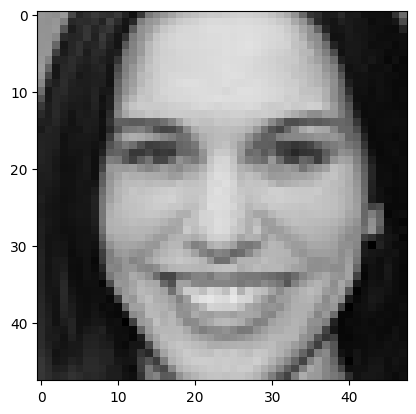

In [84]:
img = Image.open(img_path).convert('RGB')
img.resize((224, 224))
plt.imshow(img)
plt.show()

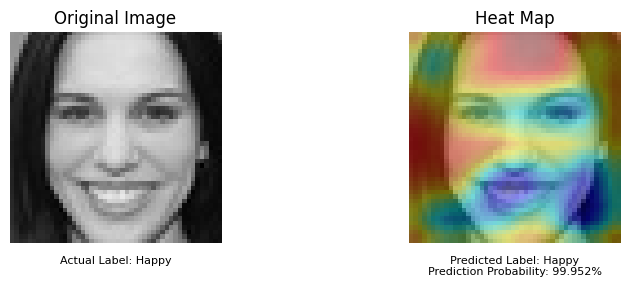

In [103]:
import matplotlib.pyplot as plt

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Display the first image on the left subplot
axes[0].imshow(orig)
axes[0].set_title('Original Image')
axes[0].text(0.5, -0.1, 'Actual Label: Happy', size=8, ha="center", transform=axes[0].transAxes)

# Display the second image on the right subplot
axes[1].imshow(output)
axes[1].set_title('Heat Map')
axes[1].text(0.5, -0.1, 'Predicted Label: Happy', size=8, ha="center", transform=axes[1].transAxes)
axes[1].text(0.5, -0.15, 'Prediction Probability: ' + str(round(preds[0][i] * 100, 3)) + '%',
              size=8, ha="center", transform=axes[1].transAxes)

# Hide the axis labels and ticks for a cleaner look
for ax in axes:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
print("Hello")

Hello


In [120]:
preds = model.predict(image)
i = np.argmax(preds[0])
decoded = i, label_map[i], preds[0][i]
print("decoded: ", decoded)
(imagenetID, label, prob) = decoded
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

1/1 [==============================] - 0s 395ms/step
decoded:  (2, 'happy', 0.9995183)
[INFO] happy: 99.95%


In [110]:
from keras.layers import Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model.load_weights("/Users/jasur/desktop/CustomNet.h5")

In [113]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i, "conv2d_11")
heatmap = cam.compute_heatmap(image)

In [114]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.6)

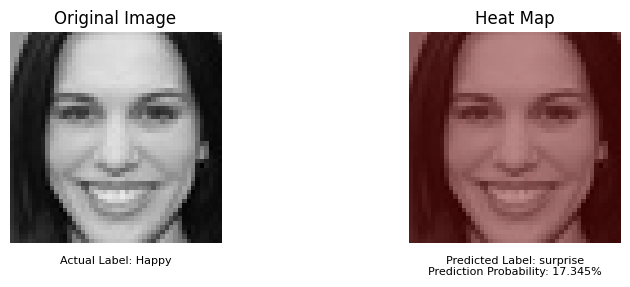

In [117]:
import matplotlib.pyplot as plt

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Display the first image on the left subplot
axes[0].imshow(orig)
axes[0].set_title('Original Image')
axes[0].text(0.5, -0.1, 'Actual Label: Happy', size=8, ha="center", transform=axes[0].transAxes)

# Display the second image on the right subplot
axes[1].imshow(output)
axes[1].set_title('Heat Map')
axes[1].text(0.5, -0.1, 'Predicted Label: ' + str(decoded[1]), size=8, ha="center", transform=axes[1].transAxes)
axes[1].text(0.5, -0.15, 'Prediction Probability: ' + str(round(preds[0][i] * 100, 3)) + '%',
              size=8, ha="center", transform=axes[1].transAxes)

# Hide the axis labels and ticks for a cleaner look
for ax in axes:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [158]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [164]:
def compile_saliency_function(model, activation_layer="sequential_7"):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

In [165]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [166]:
def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [126]:
preprocessed_input = load_image(img_path)

model = VGG16(weights='imagenet')

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

35363/35363 [==============================] - 0s 5us/step
Predicted class:
window_shade (n04590129) with probability 0.14


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [167]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

KeyError: 'sequential_7'

In [168]:
for layer in model.layers:
    print(layer.name)

input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
sequential_7
